In [1]:
from tree_detection_framework.preprocessing.preprocessing import (
    create_dataloader,
    visualize_dataloader,
)
from tree_detection_framework.detection.detector import GeometricDetector
from tree_detection_framework.postprocessing.postprocessing import (
    merge_and_postprocess_detections,
    multi_region_hole_suppression,
    single_region_hole_suppression,
    multi_region_NMS
)

/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
dataloader = create_dataloader(
    raster_folder_path="/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/chm.tif",
    chip_size=512,
    chip_stride=400,
    batch_size=3,
    output_resolution=0.2,
)

2024-12-10 23:13:29,425 - INFO - Units = Units.PIXELS
2024-12-10 23:13:29,426 - INFO - Stride = 400


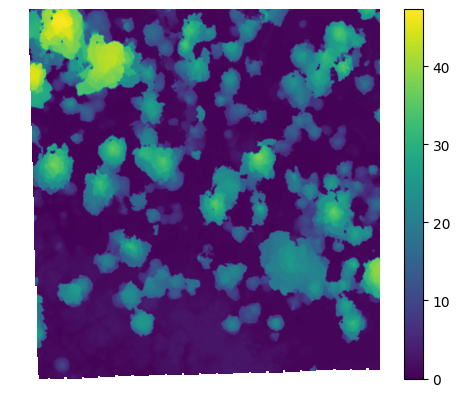

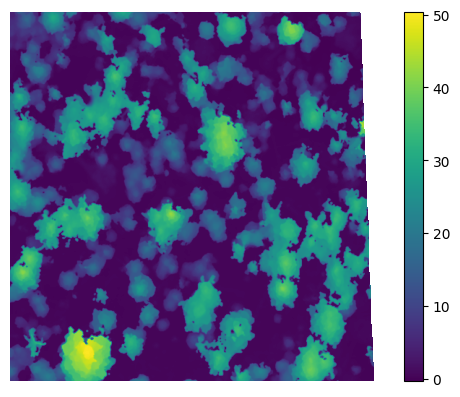

In [4]:
visualize_dataloader(dataloader, 2)

In [5]:
detector = GeometricDetector(a=0.0045, res=dataloader.sampler.res, confidence_factor="distance")
predictions = detector.predict(dataloader)

Performing prediction on batches: 100%|██████████| 6/6 [01:38<00:00, 16.49s/it]


Plotting the raw predictions before post-processing
--

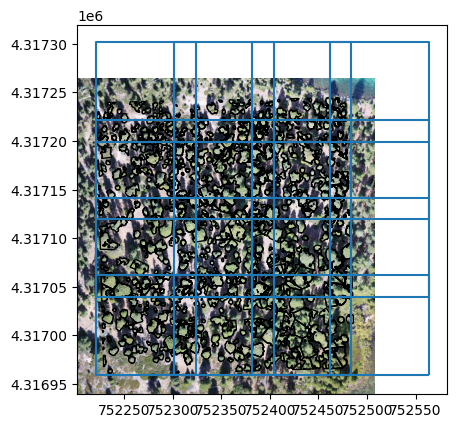

<Axes: >

In [4]:
predictions.plot(
    raster_file="/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/ortho.tif"
)

NMS
---

In [9]:
postprocessed = multi_region_NMS(predictions)

/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
2024-12-10 23:17:41,521 - INFO - Bound have overlap, running across-region NMS
/ofo-share/repos-amritha/conda/envs/tree-detection-framework/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


NMS with "distance"
--

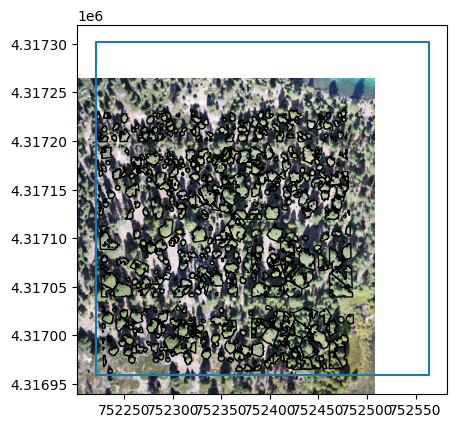

<Axes: >

In [12]:
postprocessed.plot(raster_file="/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/ortho.tif")

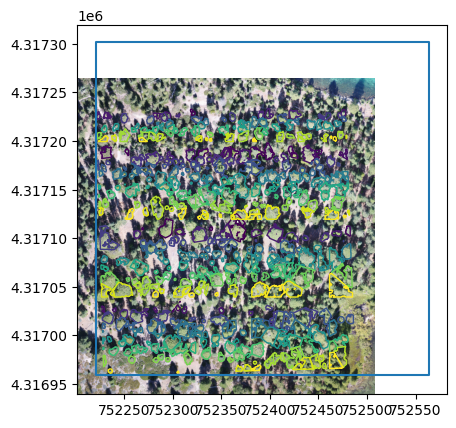

<Axes: >

In [ ]:
# Visualizing score column
postprocessed.plot(raster_file="/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/ortho.tif", visualization_column='score')

Note how higher confidence detections (yellow) are in the centers of each sub-grid/tile

NMS with "area"
--

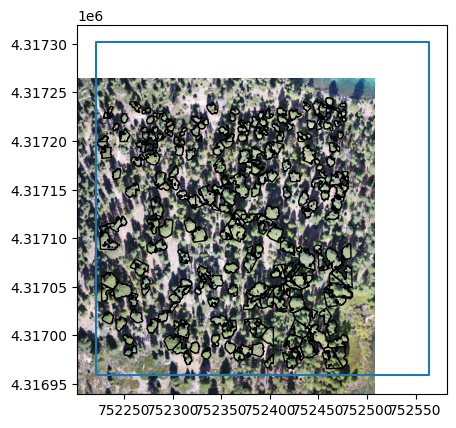

<Axes: >

In [8]:
postprocessed.plot(raster_file="/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/ortho.tif")

NMS with "height"
--

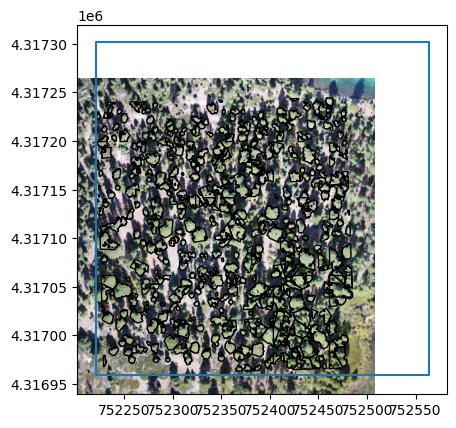

<Axes: >

In [8]:
postprocessed.plot(raster_file="/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/ortho.tif")

After suppressing polygon holes
--

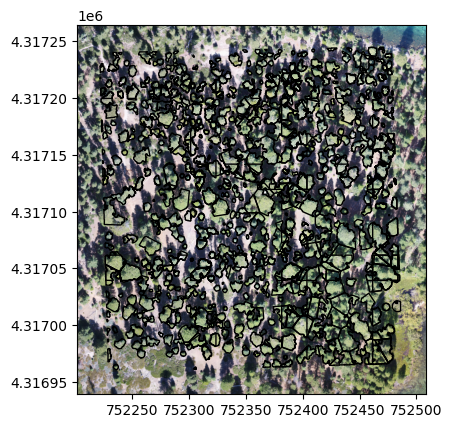

<Axes: >

In [ ]:
hole_suppressed = multi_region_hole_suppression(
    predictions
)

hole_suppressed.plot(
    raster_file="/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/ortho.tif"
)

Another way to post-process: Merging and simplifying crowns
---
This performs polygon hole supression within the function

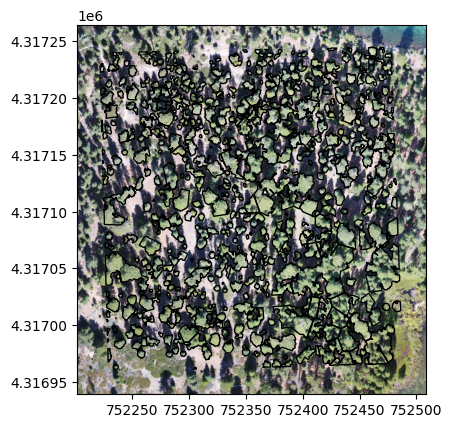

<Axes: >

In [7]:
postprocessed = merge_and_postprocess_detections(
    predictions, crs=dataloader.dataset.crs
)

postprocessed.plot(
    raster_file="/ofo-share/cv-itd-eval_data/photogrammetry-outputs/emerald-point_10a-20230103T2008/ortho.tif"
)

In [6]:
postprocessed.save(
    "/ofo-share/repos-amritha/extras/tdf/output_gpkgs/geometric_detections_multipolygon_filtered.gpkg"
)

2024-12-05 20:20:01,667 - INFO - Created 547 records


Single region hole suppression
--

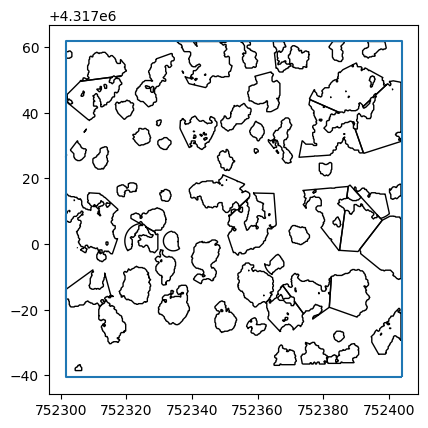

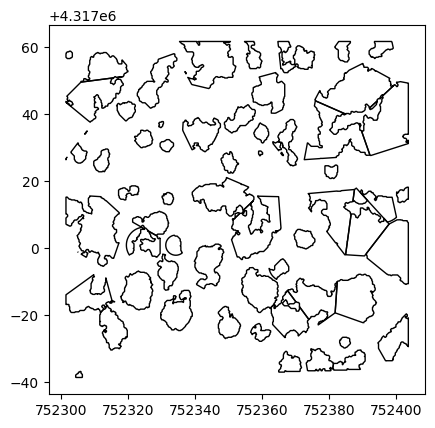

<Axes: >

In [11]:
# Get a RegionDetections object
region = predictions.region_detections[1]
region.plot()  # Before

postprocessed_region = single_region_hole_suppression(region)
postprocessed_region.plot()  # After